In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_set = datasets.CIFAR10(root='data/', download=True, transform=transform, train=True)
train_set, validation_set = torch.utils.data.random_split(train_set,[42000,8000])
test_set = datasets.CIFAR10(root='data/', download=True, transform=transform, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


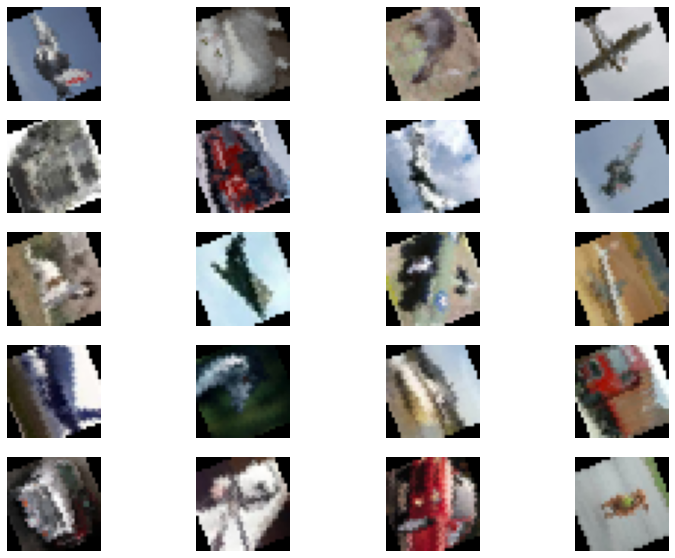

In [21]:
train_loader = torch.utils.data.DataLoader(train_set, 20, shuffle=True)
x, y = list(train_loader)[0]
x = transforms.RandomRotation(90)(x)
fig = plt.figure(figsize=(13, 10))
for i in range(20):
  fig.add_subplot(5, 4, i + 1)
  plt.axis('off')
  plt.imshow(transforms.ToPILImage()(x[i]))

In [ ]:
class CNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(4, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        # nn.Conv2d(64, 64, 3),
        # nn.BatchNorm2d(64),
        # nn.ReLU(),
        # nn.MaxPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(64, 10)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.model(x)
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_classifier = CNNClassifier()
cnn_classifier.to(device)

optimizer = torch.optim.Adam(cnn_classifier.parameters())

batch_size = 40
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)

In [ ]:
num_epochs = 20
num_iters_train = len(train_loader)
num_iters_validation = len(validation_loader)

train_losses = np.zeros((num_epochs, num_iters_train))
validation_losses = np.zeros((num_epochs, num_iters_validation))

train_acc_list = []
validation_acc_list = []

for epoch in range(num_epochs):
  train_acc = 0
  validation_acc = 0

  criterion = nn.CrossEntropyLoss()
  for it, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)
    outputs = cnn_classifier(X)

    loss = criterion(outputs, y)
    train_losses[epoch, it] = loss
    train_acc += int(torch.sum(y == torch.argmax(outputs, dim=1)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_acc = train_acc / len(train_set) * 100
  train_acc_list.append(train_acc)  
  print('Training epoch number', epoch + 1, '-->   Loss :', train_losses[epoch].sum() / len(train_loader), ' | Accuracy :', train_acc)

  criterion = nn.CrossEntropyLoss()
  for it, (X, y) in enumerate(validation_loader):
    X, y = X.to(device), y.to(device)
    outputs = cnn_classifier(X)

    loss = criterion(outputs, y)
    validation_losses[epoch, it] = loss
    validation_acc += int(torch.sum(y == torch.argmax(outputs, dim=1)))

  validation_acc = validation_acc / len(validation_set) * 100
  validation_acc_list.append(validation_acc)

  if np.argmax(validation_acc_list) == epoch:
    torch.save(cnn_classifier, 'cifar10_classifier.pth')

  print('Validation epoch number', epoch + 1, '-->   Loss :', validation_losses[epoch].sum() / len(validation_loader), ' | Accuracy :', validation_acc)

Training epoch number 1 -->   Loss : 1.1124957548436665  | Accuracy : 61.79285714285714
Validation epoch number 1 -->   Loss : 1.119429184794426  | Accuracy : 61.4625
Training epoch number 2 -->   Loss : 1.049004780167625  | Accuracy : 63.673809523809524
Validation epoch number 2 -->   Loss : 1.1061403825879097  | Accuracy : 61.9125
Training epoch number 3 -->   Loss : 1.0080716776280176  | Accuracy : 65.40714285714286
Validation epoch number 3 -->   Loss : 1.0680888766050338  | Accuracy : 63.449999999999996
Training epoch number 4 -->   Loss : 0.9719905583063762  | Accuracy : 66.64285714285715
Validation epoch number 4 -->   Loss : 1.0599772438406945  | Accuracy : 63.74999999999999
Training epoch number 5 -->   Loss : 0.9418968868255615  | Accuracy : 67.38809523809523
Validation epoch number 5 -->   Loss : 1.048909021615982  | Accuracy : 64.53750000000001
Training epoch number 6 -->   Loss : 0.9130079487391881  | Accuracy : 68.57142857142857
Validation epoch number 6 -->   Loss : 1.04

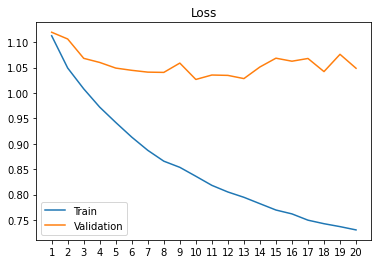

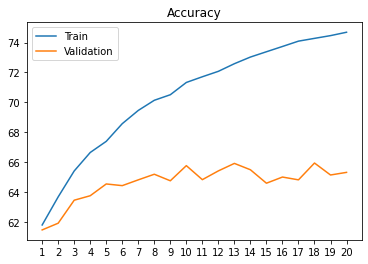

In [ ]:
x_label = np.arange(1, num_epochs + 1)
y_training_loss = np.sum(train_losses, axis=1) / len(train_loader)
y_validation_loss = np.sum(validation_losses, axis=1) / len(validation_loader)
y_training_acc = np.array(train_acc_list)
y_validation_acc = np.array(validation_acc_list)


plt.plot(x_label, y_training_loss)
plt.plot(x_label, y_validation_loss)
plt.xticks(x_label)
plt.title("Loss")
plt.legend(['Train', 'Validation'])
plt.figure()

plt.plot(x_label, y_training_acc)
plt.plot(x_label, y_validation_acc)
plt.xticks(x_label)
plt.title("Accuracy")
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
cnn_classifier = torch.load('cifar10_classifier.pth')

with torch.no_grad():
    test_acc = 0
    missclassified_images = []
    counter = 0
    confusion_matrix = np.zeros((10, 10))

    for it, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        outputs = cnn_classifier(X)
        confusion_matrix[y, torch.argmax(outputs, dim=1)] += 1
        test_acc += int(torch.sum(y == torch.argmax(outputs, dim=1)))
        for i in range(len(y)):
          confusion_matrix[y[i], torch.argmax(outputs[i])] += 1

        miss_indices = []
        if counter < 20:
          for i in range(len(y)):
            if y[i] != torch.argmax(outputs[i]):
              miss_indices.append(i)
          if len(miss_indices) != 0:
            for num in miss_indices:
              counter += 1
              missclassified_images.append((X[num], int(y[num]), int(torch.argmax(outputs[num]))))
      
    test_acc = test_acc / len(test_set) * 100
    print('Accuracy on test set :', test_acc)

Accuracy on test set : 65.10000000000001


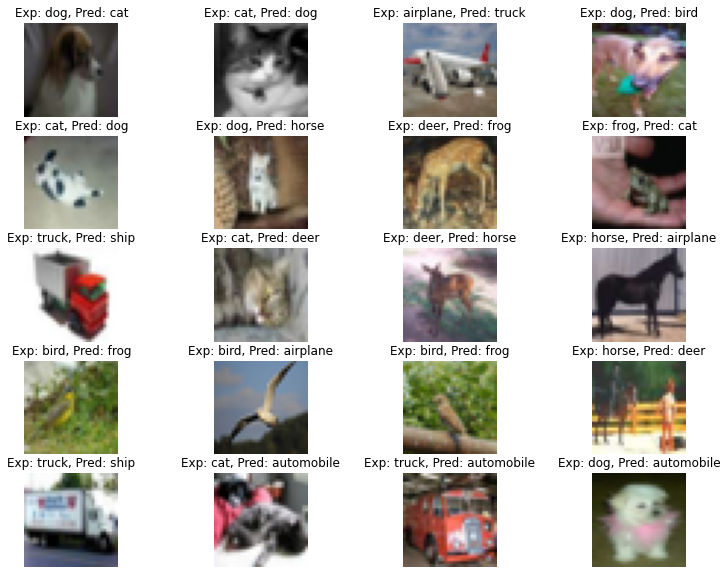

In [ ]:
fig = plt.figure(figsize=(13, 10))
label_objects = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
for i in range(20):
  fig.add_subplot(5, 4, i + 1)
  plt.title('Exp: {0}, Pred: {1}'.format(label_objects[missclassified_images[i][1]], label_objects[missclassified_images[i][2]]))
  plt.axis('off')
  plt.imshow(transforms.ToPILImage()(missclassified_images[i][0]))

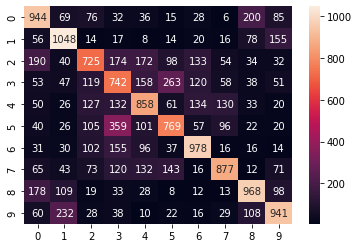

In [ ]:
import pandas as pd
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, fmt='g')
plt.show()